# Segmentation of Indian Traffic

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [3]:
!wget --header="Host: doc-08-6g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr;q=0.8" --header="Cookie: AUTH_9o29vf87frcchs51bimaeds4ogrnh8go_nonce=3ma7pqph7h7o8" --header="Connection: keep-alive" "https://doc-08-6g-docs.googleusercontent.com/docs/securesc/1j2h557637q7lk1bjoevgo67tmc7i4rp/sqmho7d3d7ok30go9lhslshqe81rr9gs/1617974700000/00484516897554883881/17803620188846887884/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=3ma7pqph7h7o8&user=17803620188846887884&hash=r0t4f7b22qbqfvmdstqdc1aam9l9te0j" -c -O 'data.zip'

--2021-04-09 13:26:08--  https://doc-08-6g-docs.googleusercontent.com/docs/securesc/1j2h557637q7lk1bjoevgo67tmc7i4rp/sqmho7d3d7ok30go9lhslshqe81rr9gs/1617974700000/00484516897554883881/17803620188846887884/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=3ma7pqph7h7o8&user=17803620188846887884&hash=r0t4f7b22qbqfvmdstqdc1aam9l9te0j
Resolving doc-08-6g-docs.googleusercontent.com (doc-08-6g-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-08-6g-docs.googleusercontent.com (doc-08-6g-docs.googleusercontent.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip                [  <=>               ]   2.18G  36.8MB/s    in 27s     

2021-04-09 13:26:36 (82.5 MB/s) - ‘data.zip’ saved [2339740971]



In [4]:
!unzip -q data.zip

In [5]:
!rm -rf /content/data.zip

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    dir_list = sorted(os.listdir(os.path.join(root_dir , 'images/')))
    images_list = []
    mask_list = []
    for i in dir_list:
        images_path = 'data/images/' + i
        mask_path = 'data/mask/' + i
        
        img_dirs = sorted(os.listdir(images_path))
        mask_dirs = sorted(os.listdir(mask_path))
    
        for j in range(len(img_dirs)):
            images_list.append(images_path+ '/'+ img_dirs[j])
            mask_list.append(mask_path+ '/'+ mask_dirs[j])     

    data_df = pd.DataFrame({'image': images_list, 'json':mask_list})
    return data_df

In [ ]:
data_df = return_file_names_df('data/')
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels = []
    for i in data_df['json']:
        f = open(i,)
        data = json.load(f)
        for j in data['objects']:
            unique_labels.append(j['label'])
    return set(unique_labels)

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [6]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    
    f = open(file,)
    data = json.load(f)
    label = []
    vertexlist = []
    for i in data['objects']:
        label.append(i['label'])
        row = [tuple(k) for k in i['polygon']]
        vertexlist.append(row)
    w = data['imgWidth']
    h = data['imgHeight']
    
    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

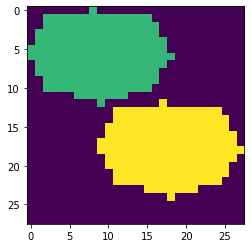

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    path_list = []
    for i in data_df['json']:
        
        w, h, label, vertexlist = get_poly(i)

        img = Image.new("RGB", (w,h))
        img1 = ImageDraw.Draw(img)

        for j in range(len(vertexlist)):
          if len(vertexlist[j]) > 1:
            img1.polygon(vertexlist[j], fill = label_clr[label[j]])

        #making directory
        file_dir = i.split('/')
        file_dir[1] = 'output'
        if not os.path.exists('/'.join(file_dir[:-1])):
            os.makedirs('/'.join(file_dir[:-1]))
            
        #editing directory 
        file_name = file_dir[-1].split('.')
        file_name[1] = 'png'
        file_name = '.'.join(file_name)
        file_dir[-1] = file_name
        file_dir = "/".join(file_dir)
        path_list.append(file_dir)
        img = np.array(img)
        im = Image.fromarray(img[:,:,0])
        im.save(file_dir, 'PNG')
    
    data_df['mask'] = path_list
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


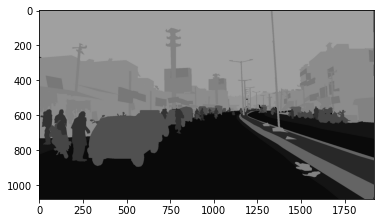

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [ ]:
!zip -r /content/drive/MyDrive/assgn29/output.zip /content/data/output

In [7]:
!unzip -q /content/drive/MyDrive/assgn29/output.zip -d /content/data

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
     In case of binary class segmentation
     where y_'s are prediction probabilities 
     dice_coef = 2*sum(y*y_)/(sum(y) + y_)   #(2*Intersection/union)
     dice_loss = 1 - dice_coef
* 2. Range of the loss function
     [0,1]
* 3. Interpretation of loss function
     Near to 0 means model is performing well 
* 4. Write your understanding of the loss function, how does it helps in segmentation
     If model results in less intersection(num) then it results to less dice_coef and more dice_loss according <br>     to above formulation and then in next epoch model will try to decrease that dice_loss. 
</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [8]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 21kB/s 
     |████████████████████████████████| 3.0MB 51.6MB/s 
     |████████████████████████████████| 460kB 47.7MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [9]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 8.7MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [10]:
!pip install -U segmentation-models

In [11]:
import tensorflow as tf
import keras 

print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.1


Using TensorFlow backend.


In [12]:
import segmentation_models as sm
# from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import random as rn
import imgaug.augmenters as iaa

Segmentation Models: using `keras` framework.


In [13]:
data_df = pd.read_csv('/content/drive/MyDrive/assgn29/preprocessed_data.csv')
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4008 non-null   object
 1   json    4008 non-null   object
 2   mask    4008 non-null   object
dtypes: object(3)
memory usage: 94.1+ KB


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df[['image','mask']].values, test_size=0.15, random_state=42)
print(X_train.shape,X_test.shape)

(3406, 2) (602, 2)


In [15]:
aug1 = iaa.Fliplr(0.25)
aug2 = iaa.Flipud(0.25)
aug3 = iaa.Emboss(alpha=(0.25), strength=0.5)
aug4 = iaa.DirectedEdgeDetect(alpha=(0.5), direction=(1.0))

In [16]:
class Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, X, classes, w, h, augment):
        
        self.w = w
        self.h = h
        # the paths of images
        self.images_fps = X[:,0]
        # the paths of segmentation images
        self.masks_fps = X[:,1]
        # giving labels for each class
        self.class_values = classes
        self.augment = augment

    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_NEAREST)

        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.augment == True:  
          a = np.random.uniform()
          if a<0.25:
              image = aug1.augment_image(image)
              image_mask = aug1.augment_image(image_mask)
          elif a<0.5:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.75:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          else:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
        
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
      
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [17]:
#loading dataset
w = 256
h = 256
classes = np.unique(np.array(list(label_clr.values())))
train_dataset = Dataset(X_train, classes, w, h, augment = True)
test_dataset  = Dataset(X_test, classes, w, h, augment = False)

train_dataloader = Dataloder(train_dataset, batch_size=10, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=10, shuffle=True)

print(train_dataloader[0][0].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0].shape, test_dataloader[0][1].shape)

(10, 256, 256, 3) (10, 256, 256, 21)
(10, 256, 256, 3) (10, 256, 256, 21)


In [ ]:
tf.keras.backend.set_image_data_format('channels_last')
model = Unet('resnet34', encoder_weights = 'imagenet',encoder_freeze= True,classes=21, activation='softmax', input_shape=(w,h,3))
model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

In [ ]:
optim = keras.optimizers.Adam()

focal_loss = sm.losses.cce_dice_loss

weight_path = '/content/drive/MyDrive/assgn29/best_model.h5'
log_path = '/content/drive/MyDrive/assgn29/log.csv'
callbacks = [
    keras.callbacks.ModelCheckpoint(weight_path, save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),  \
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0,patience=2),
    # keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=5),
    keras.callbacks.CSVLogger(log_path, separator=',', append='True')
]

model.load_weights(weight_path)
model.compile(optim, focal_loss, metrics=[iou_score])
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),initial_epoch=53, epochs=100,\
                              validation_data=test_dataloader,validation_steps = len(test_dataloader),\
                              callbacks = callbacks)

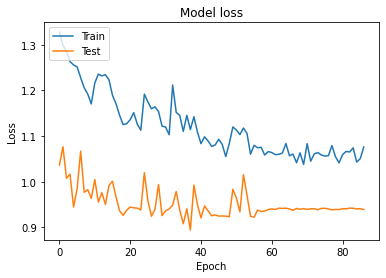

In [ ]:
# Plot training & validation loss values
result = pd.read_csv('/content/drive/MyDrive/assgn29/log.csv', sep = ',')

plt.plot(result['loss'])
plt.plot(result['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

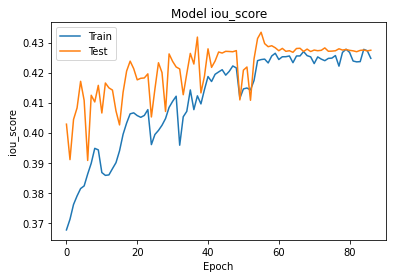

In [ ]:
# Plot training & validation iou_score values

plt.plot(result['iou_score'])
plt.plot(result['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

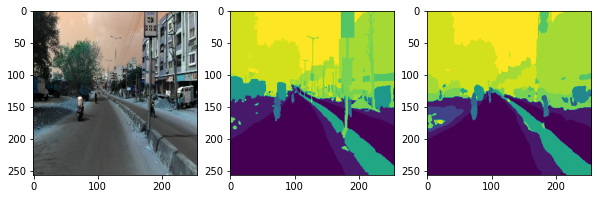

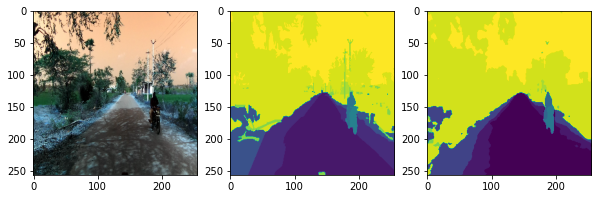

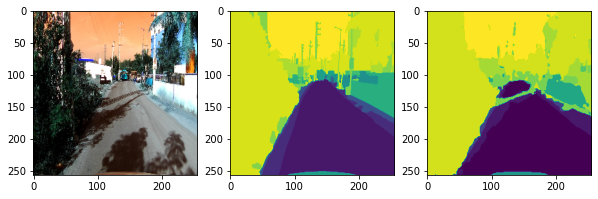

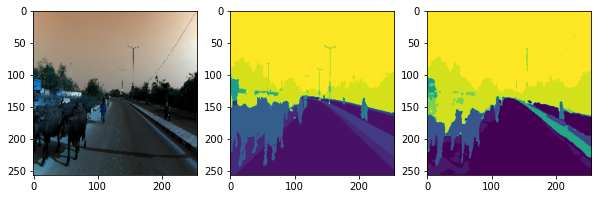

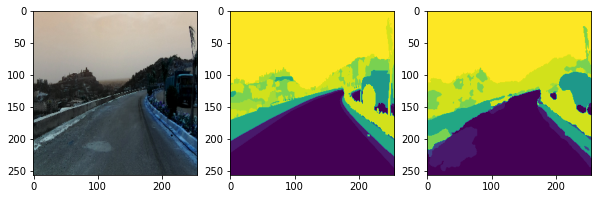

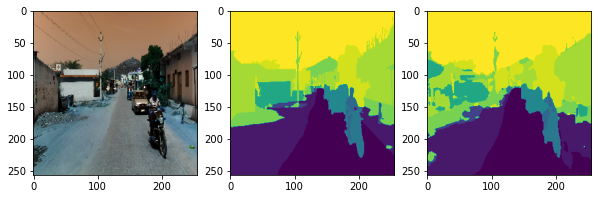

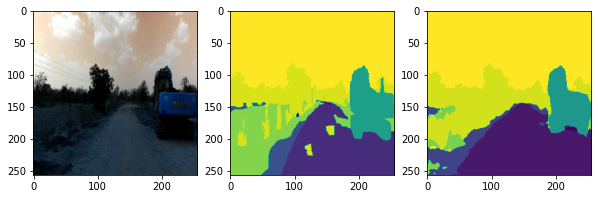

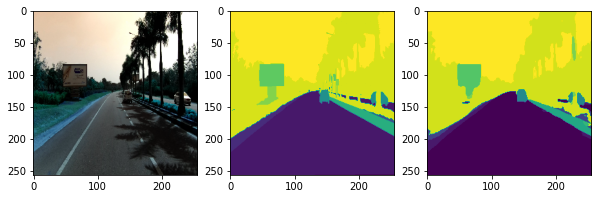

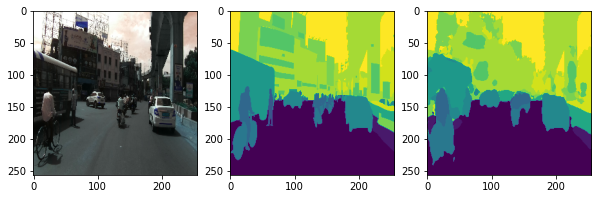

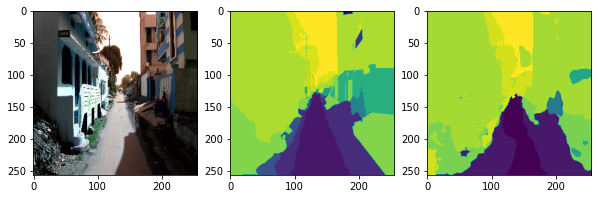

In [ ]:
model.load_weights('/content/drive/MyDrive/assgn29/best_model.h5')
for i in X_test[:10]:
    #original image
    image = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])

    #original segmentation map
    image_mask = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(np.argmax(predicted, axis=-1)[0])
    plt.show()

# Task 3: Training CANet

In [18]:
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [25]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel,  filters, stride, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.conv2d_1 = Conv2D(self.F1, 1, padding='same')
        self.conv2d_2 = Conv2D(self.F2, 3, padding = 'same', strides=self.stride)
        self.conv2d_3 = Conv2D(self.F3, 1, padding='same')
        self.conv2d_p = Conv2D(self.F3, 3, padding = 'same', strides=self.stride)
        self.batch_norm1 = BatchNormalization()
        self.batch_norm2 = BatchNormalization()
        self.batch_norm3 = BatchNormalization()
        self.batch_normp = BatchNormalization()        
        self.activation = Activation('relu')
        self.add = Add()

    def call(self, X):
        # write the architecutre that was mentioned above
        output = self.conv2d_1(X)
        output = self.batch_norm1(output)
        output = self.activation(output)
        
        output = self.conv2d_2(output)
        output = self.batch_norm2(output)
        output = self.activation(output)
        
        output = self.conv2d_3(output)
        output = self.batch_norm3(output)

        #parallel conv
        p_output = self.conv2d_p(X)
        p_output = self.batch_normp(p_output)
        p_output = self.activation(p_output)
        
        output = self.add([output, p_output])
        output = self.activation(output)
        return output
        

In [28]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel,  filters, name="identity block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv2d_1 = Conv2D(self.F1, 1, padding='same')
        self.conv2d_2 = Conv2D(self.F2, 3, padding = 'same')
        self.conv2d_3 = Conv2D(self.F3, 1, padding='same')
        self.batch_norm1 = BatchNormalization()
        self.batch_norm2 = BatchNormalization()
        self.batch_norm3 = BatchNormalization()
        self.activation = Activation('relu')
        self.add = Add()

    def call(self, X):
        # write the architecutre that was mentioned above
        output = self.conv2d_1(X)
        output = self.batch_norm1(output)
        output = self.activation(output)
        
        output = self.conv2d_2(output)
        output = self.batch_norm2(output)
        output = self.activation(output)
        
        output = self.conv2d_3(output)
        output = self.batch_norm3(output)
        
        #parallel conv
        output = self.add([output, X])
        output = self.activation(output)
        return output

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [21]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.global_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1,1,64))
        self.batch_norm = BatchNormalization()
        self.activation = Activation('relu')
        self.conv2d = Conv2D(64, 1, padding='same')
        self.upsampling = UpSampling2D((32,32), interpolation = 'bilinear')

    def call(self, X):
        # implement the global flow operation
        output = self.global_pool(X)
        output = self.reshape(output)
        output = self.batch_norm(output)
        output = self.activation(output)
        output = self.conv2d(output)
        output = self.upsampling(output)
        return output

In [22]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.conv_2d_1 = Conv2D(64, 3, padding='same')
        self.conv_2d_2 = Conv2D(64, 3, padding='same')
        self.conv_2d_3 = Conv2D(64, 1, padding='same')
        self.conv_2d_4 = Conv2D(64, 1, padding='same')
        self.concatenate = Concatenate(axis=-1)
        self.averagepool = AveragePooling2D(2)
        self.activation_1 = Activation('relu')
        self.activation_2 = Activation('sigmoid')
        self.multiply = Multiply()
        self.add = Add()
        self.upsample = UpSampling2D(2)


    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        output = self.concatenate([INP,FLOW])
        output = self.averagepool(output)
        output = self.conv_2d_1(output)
        output = self.conv_2d_2(output)

        output_1 = self.conv_2d_3(output)
        output_1 = self.activation_1(output)
        output_1 = self.conv_2d_4(output)
        output_1 = self.activation_2(output)

        output_1 = self.multiply([output, output_1])
        output = self.add([output, output_1])
        
        output = self.upsample(output)
        return output

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [30]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv_2d_1 = Conv2D(64, 3, padding='same')
        self.globalaverage = GlobalAveragePooling2D()
        self.reshape = Reshape((1,1,64))
        self.conv_2d_2 = Conv2D(64, 1, padding='same')
        self.batch_norm = BatchNormalization()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()
        self.upsampling = UpSampling2D(2, interpolation = 'bilinear')

    def call(self, X):
        # implement the FSM modules based on image in the above cells
        output = self.conv_2d_1(X)
  
        output_1 = self.globalaverage(output)
        output_1 = self.reshape(output_1)
        output_1 = self.conv_2d_2(output_1)
        output_1 = self.batch_norm(output_1)
        output_1 = self.activation(output_1)

        output = self.multiply([output, output_1])
        output = self.upsampling(output)
        return output

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [26]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv2d_1 = Conv2D(32, kernel_size = (1,7), padding='same', strides = 1)
        self.conv2d_2 = Conv2D(32, kernel_size = (7,1), padding='same', strides = 1)
        self.conv2d_3 = Conv2D(32, kernel_size = (1,7), padding='same', strides = 1)
        self.conv2d_4 = Conv2D(32, kernel_size = (7,1), padding='same', strides = 1)
        self.conv2d_5 = Conv2D(32, kernel_size = (3,3), padding='same', strides = 1)
        self.add = Add()

    def call(self, X):
        # please implement the above mentioned architecture
        output = self.conv2d_1(X)
        output = self.conv2d_2(output)

        output_1 = self.conv2d_3(X)
        output_1 = self.conv2d_4(output_1)

        output = self.add([output, output_1])

        output_1 = self.conv2d_5(output)
        output = self.add([output, output_1])

        return output

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [31]:
K.clear_session()
X_input = Input(shape=(256,256,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

#C1
c1 = convolutional_block(kernel=3, filters=[4,4,8], stride = 2, name="c1_conv_block")(X)
c1 = identity_block(kernel=3,  filters=[4,4,8], name="c1_identity_block")(c1)

#C2
c2 = convolutional_block(kernel=3, filters=[8,8,16], stride = 2, name="c2_conv_block")(c1)
c2 = identity_block(kernel=3,  filters=[8,8,16], name="c2_identity_block_1")(c2)
c2 = identity_block(kernel=3,  filters=[8,8,16], name="c2_identity_block_2")(c2)

#C3
c3 = convolutional_block(kernel=3, filters=[16,16,32], stride = 1, name="c3_conv_block")(c2)
c3 = identity_block(kernel=3,  filters=[16,16,32], name="c3_identity_block_1")(c3)
c3 = identity_block(kernel=3,  filters=[16,16,32], name="c3_identity_block_2")(c3)
c3 = identity_block(kernel=3,  filters=[16,16,32], name="c3_identity_block_3")(c3)

#C4
c4 = convolutional_block(kernel=3, filters=[32,32,64], stride = 1, name="c4_conv_block")(c3)
c4 = identity_block(kernel=3,  filters=[32,32,64], name=f"c4_identity_block_1")(c4)
c4 = identity_block(kernel=3,  filters=[32,32,64], name="c4_identity_block_2")(c4)
c4 = identity_block(kernel=3,  filters=[32,32,64], name="c4_identity_block_3")(c4)
c4 = identity_block(kernel=3,  filters=[32,32,64], name="c4_identity_block_4")(c4)

#CAM
cf_1 = global_flow(name='global_flow')(c4)
cf_2 = context_flow(name='context_flow_1')([c4, cf_1])
cf_3 = context_flow(name='context_flow_2')([c4, cf_2])
cf_4 = context_flow(name='context_flow_3')([c4, cf_3])

cf_sum = Add()([cf_1,cf_2,cf_3,cf_4])

feature_selection = fsm(name ='fsm')(cf_sum)

#decoder
global_conv = agcn(name = 'agcn')(c1)
output = Concatenate(axis=-1, name='conc')([global_conv, feature_selection])
output = Conv2D(21, 3, padding = 'same')(output)
output = UpSampling2D(4)(output)
output = Activation('softmax')(output)
print(output.shape)

(None, 256, 256, 21)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [32]:
# write the complete architecutre

model_1 = Model(inputs = X_input, outputs = output)

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

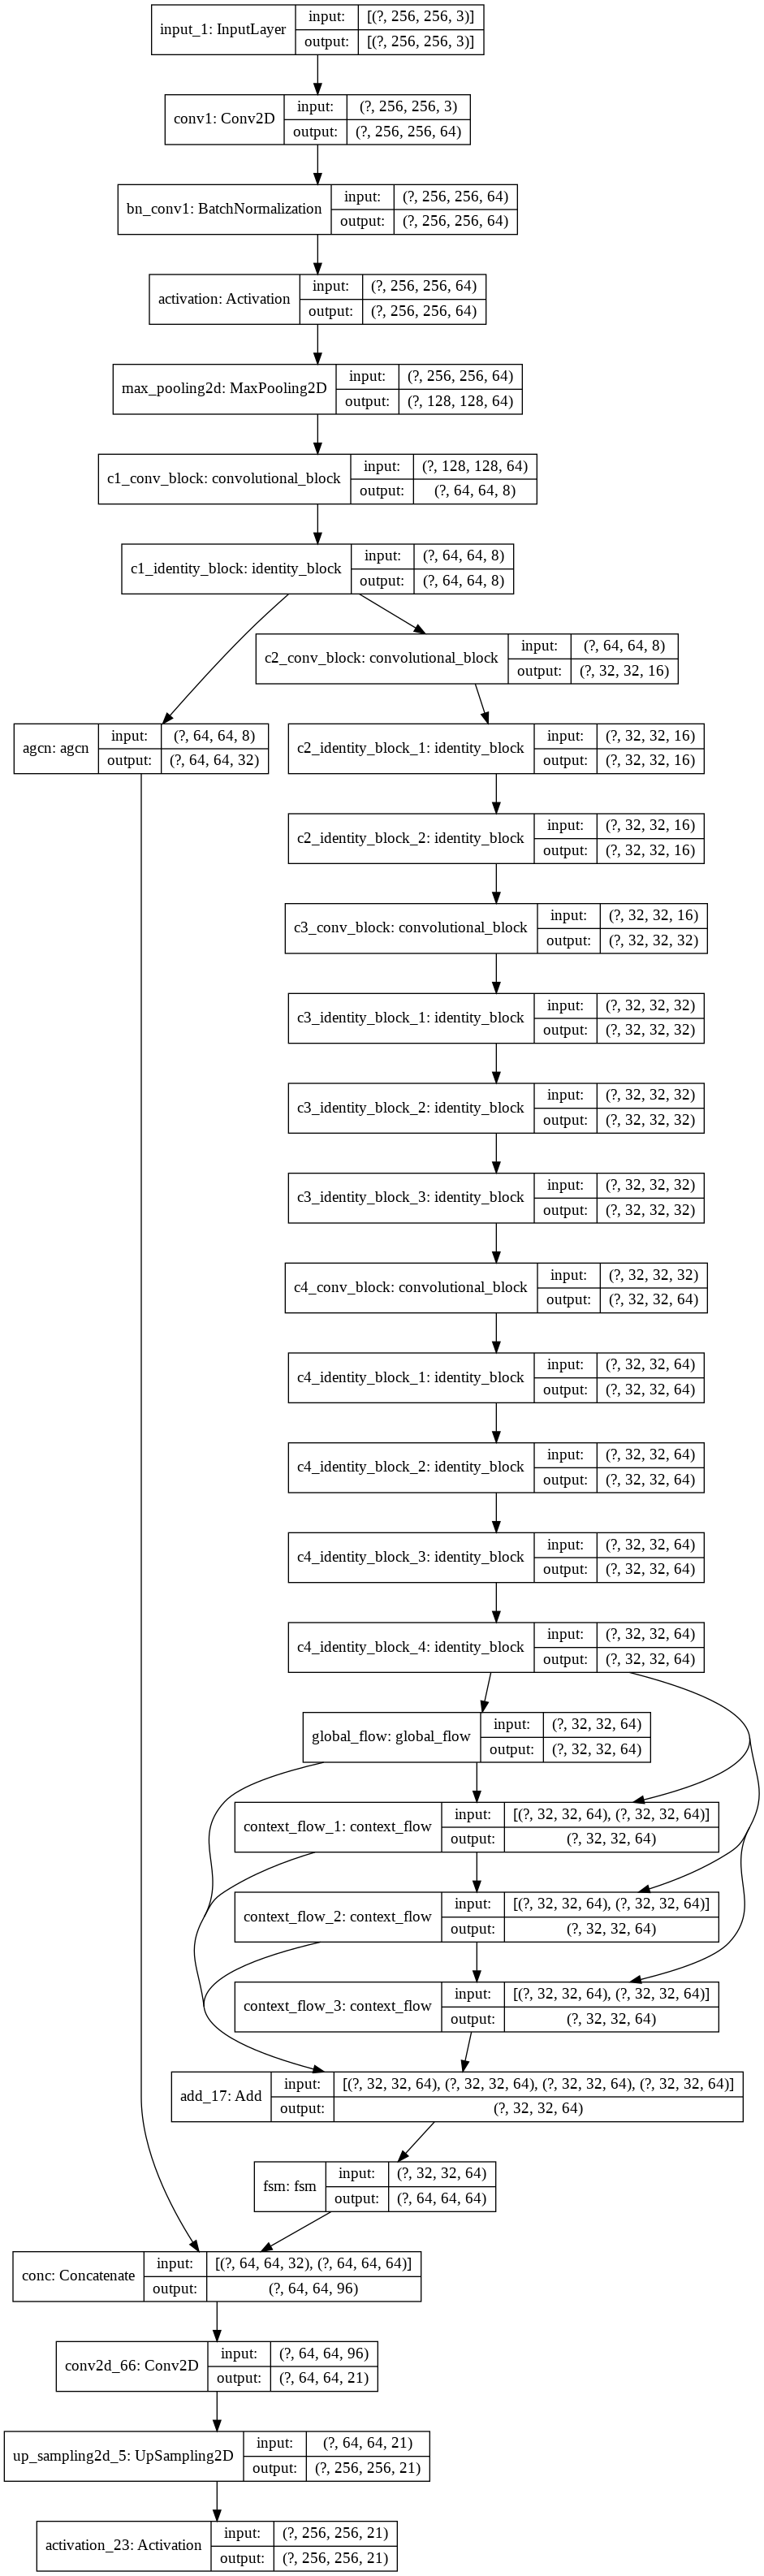

In [33]:
tf.keras.utils.plot_model(
    model_1, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
optim = keras.optimizers.Adam()

focal_loss = sm.losses.cce_dice_loss

weight_path = '/content/drive/MyDrive/assgn29/canet_best_model.h5'
log_path = '/content/drive/MyDrive/assgn29/canet_log.csv'
callbacks = [
    keras.callbacks.ModelCheckpoint(weight_path, save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),  \
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0,patience=2),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    keras.callbacks.CSVLogger(log_path, separator=",", append=True)
]

model_1.load_weights(weight_path)
iou_score = sm.metrics.IOUScore(threshold=0.5)
model_1.compile(optim, focal_loss, metrics=[iou_score])
history = model_1.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),initial_epoch=13, epochs=15,\
                              validation_data=test_dataloader,validation_steps = len(test_dataloader),\
                              callbacks = callbacks
                              )

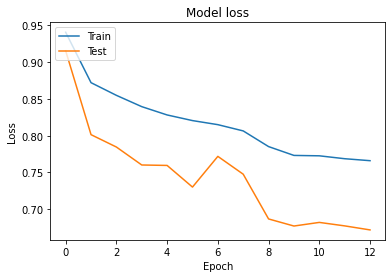

In [41]:
result = pd.read_csv('/content/drive/MyDrive/assgn29/canet_log.csv', sep = ',')

plt.plot(result['loss'])
plt.plot(result['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

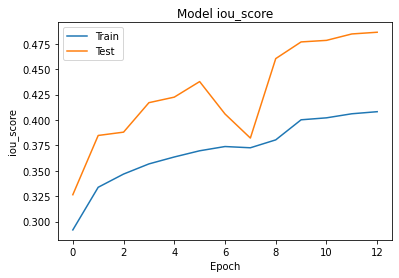

In [42]:
plt.plot(result['iou_score'])
plt.plot(result['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

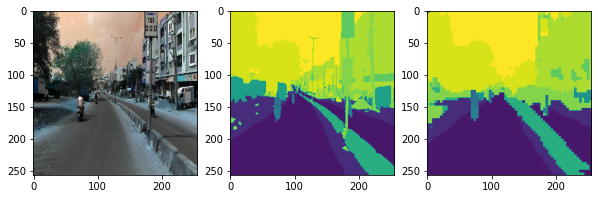

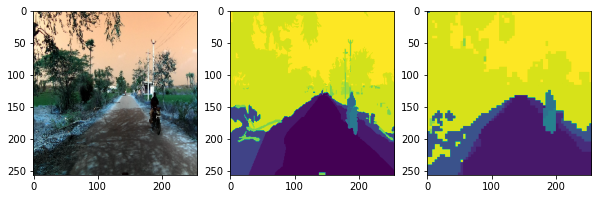

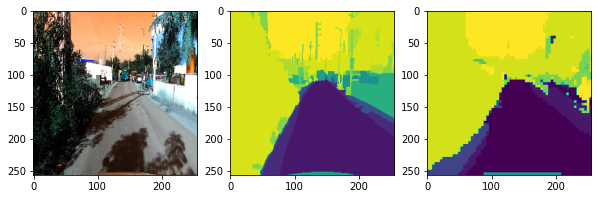

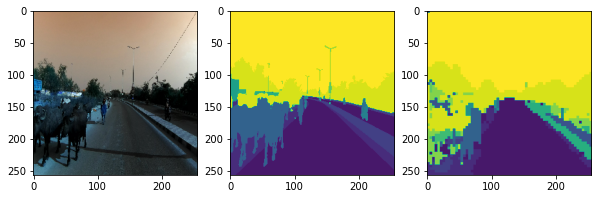

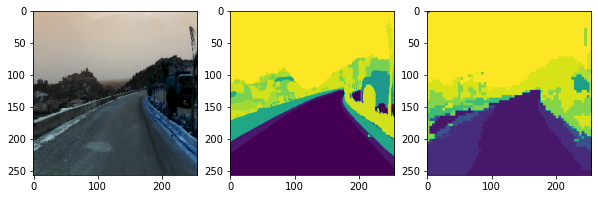

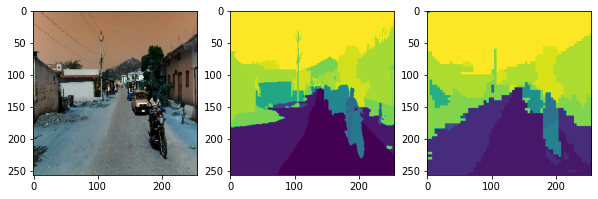

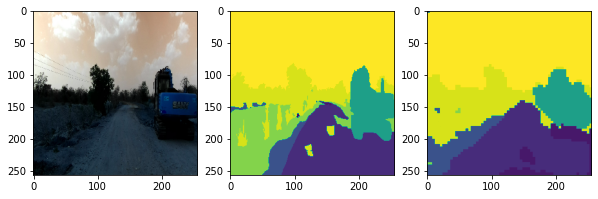

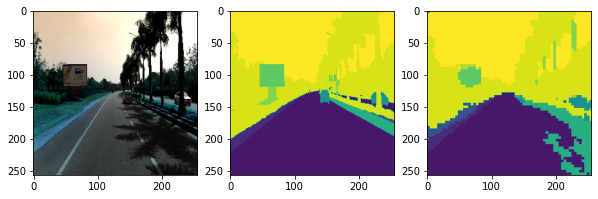

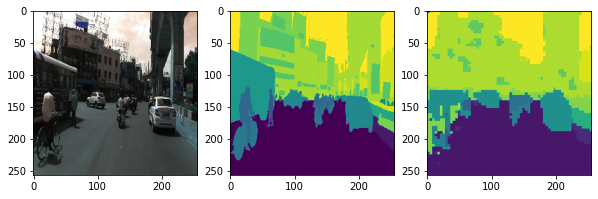

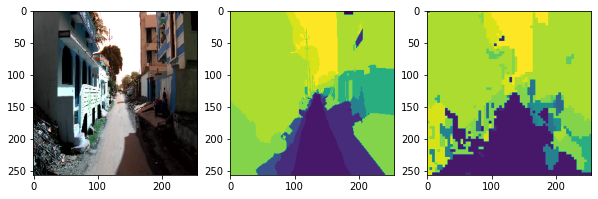

In [37]:
# model_1.load_weights('/content/drive/MyDrive/assgn29/canet_best_model.h5')
for i in X_test[:10]:
    #original image
    image = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256), interpolation=cv2.INTER_NEAREST) 
    
    #predicted segmentation map
    predicted  = model_1.predict(image[np.newaxis,:,:,:])

    #original segmentation map
    image_mask = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation=cv2.INTER_NEAREST)
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(np.argmax(predicted, axis=-1)[0])
    plt.show()

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations